In [1]:
%%time
# Data exploration
import matplotlib.pyplot as plt

# Data processing
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from numpy import array
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

# Experimental setup
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, GridSearchCV
# from imblearn.over_sampling import SMOTE, RandomOverSampler
# from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve

# Importing machine learning algorithms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# For computing the scores etc
from imblearn.pipeline import Pipeline
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, log_loss

Wall time: 4.23 s


In [2]:
# Reading the files
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
train.shape

(200000, 202)

In [4]:
# subsetting the dataset
# train = train.iloc[0:1000,:]

In [5]:
# putting all the df colname in a list
dfcols = list(train.columns)

# exculdig target and index columns
features = dfcols[2:]
target = dfcols[1]

## Feature Selection

### Calculating Feature Importance using Fisher Score

In [7]:
%%time
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.

    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

Wall time: 0 ns


In [7]:
predictors = features

In [9]:
%%time
# Calculate Fisher Score for all variable
fs = FisherScore(train, target, predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False)
fs_df.head()

Wall time: 1.88 s


,predictor,fisherscore
81,var_81,0.180642
139,var_139,0.168071
12,var_12,0.156917
6,var_6,0.152685
110,var_110,0.145658


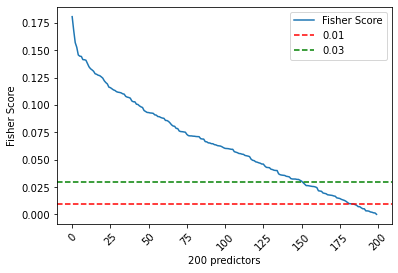

Wall time: 274 ms


In [10]:
%%time
# Visualize the Fisher Score
plt.plot(fs_df['fisherscore'].values.squeeze())
plt.axhline(y=0.01, linestyle='dashed', color='red')
plt.axhline(y=0.03, linestyle='dashed', color='green')
plt.xticks(rotation=45)
plt.xlabel(str(fs_df.shape[0]) + ' predictors')
plt.ylabel('Fisher Score')
plt.legend(['Fisher Score', '0.01', '0.03'])
plt.show()

In [6]:
%%time
# Check how AUC change when add more variables: Top n vars
# fs_scores = []
# top_n_vars = 200
# for i in range(1, top_n_vars+1):
#     if i % 100 == 0: print('Added # top vars :', i)
#     top_n_predictors = fs_df['predictor'][:i]
#     clf = LogisticRegression()
#     fs_scores.append(cross_validate(clf, train[top_n_predictors], train[target].values.squeeze(),
#                                     scoring='roc_auc', cv=5, verbose=0, n_jobs=-1, return_train_score=True))

# # How the AUC curve looks like when adding top vars
# plt.plot([s['train_score'].mean() for s in fs_scores], color='blue')
# plt.plot([s['test_score'].mean() for s in fs_scores], color='red')
# plt.xlabel('# vars')
# plt.ylabel('AUC')
# plt.legend(['train', 'test'])
# plt.show()

Wall time: 0 ns


### Calculating feature importance using logistic regression

In [11]:
# USING LOGISTIC REGRESSION TO FIT EACH FEATURE ONE BY ONE; WE CAN CALCULATE THE AUC ON EACH FEATURE FOR THE TRAINING DATA

# Define the function score that will be used to assess the accuracy of each feature

def score (dataSet: DataFrame, withModel: LogisticRegression, feature: str):
    dataSet[f"p donation {feature}"] = DataFrame(withModel.predict_proba(dataSet[[feature]]))[1]

# Define the function buildLogisticRegression that will be used to instanciate and train a logistic model

def buildLogisticRegression (onDataSet: DataFrame, forVariable: str, target: str) -> LogisticRegression:
    # 1.
    logisticRegressionModel = LogisticRegression(solver = "lbfgs", max_iter = 500)
    # 2.
    logisticRegressionModel.fit(onDataSet[[forVariable]], onDataSet[target])
    # 3. 
    return logisticRegressionModel

In [12]:
# CALCULATING THE AUC FOR EACH FEATURE ON TEH LOGISTIC REGRESSION MODEL. WE KEEP THE FEATURES THAT HAVE AUC ABOVE 0.53
aucsTrain = []
aucsTest  = []
for feature in features:
    mod = buildLogisticRegression(onDataSet = train, forVariable = feature, target = target)
    score(dataSet =  train, withModel = mod, feature = feature)
    score(dataSet =  train, withModel = mod, feature = feature)
    
    aucsTrain.append(roc_auc_score(array(train[target]),array(train[f"p donation {feature}"])))
    aucsTest.append(roc_auc_score(array(train[target]),array(train[f"p donation {feature}"])))

aucs = {"features":features,"training":aucsTrain,"test":aucsTest}


df_aucs = DataFrame(aucs).sort_values(by=["test"], ascending = False)
df_aucs['to_keep'] = 1
df_aucs.loc[df_aucs['test'] <= 0.53, 'to_keep'] = 0

df_aucs

,features,training,test,to_keep
81,var_81,0.567239,0.567239,1
139,var_139,0.565581,0.565581,1
6,var_6,0.559942,0.559942,1
12,var_12,0.559281,0.559281,1
110,var_110,0.556138,0.556138,1
146,var_146,0.555709,0.555709,1
76,var_76,0.554846,0.554846,1
53,var_53,0.554683,0.554683,1
21,var_21,0.553892,0.553892,1
174,var_174,0.553193,0.553193,1


<AxesSubplot:xlabel='to_keep', ylabel='count'>

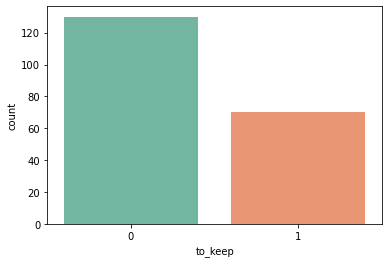

In [13]:
# sns.set_theme(style="darkgrid")
sns.countplot(x='to_keep', data = df_aucs, palette="Set2")

In [14]:
df_aucs.groupby("to_keep").count()

,features,training,test
to_keep,,,
0,130,130,130
1,70,70,70


### Splitting the data into train and validation

In [15]:
#splitting into train and validation
train, validation = train_test_split(train, test_size=0.30, random_state = 1)

### Calculating the feature importance using lightgbm

In [16]:
import lightgbm as lgb

# Initialize an empty array to hold feature importances
feature_importances = np.zeros(len(features))

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

# Fit the model twice to avoid overfitting
for i in range(2):
    # Train using early stopping
    model.fit(train[features], train[target], early_stopping_rounds=500, eval_set = [(validation[features], validation[target])],
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_


Training until validation scores don't improve for 500 rounds
[200]	valid_0's auc: 0.880918	valid_0's binary_logloss: 0.374761
[400]	valid_0's auc: 0.885978	valid_0's binary_logloss: 0.314839
[600]	valid_0's auc: 0.885042	valid_0's binary_logloss: 0.284567
[800]	valid_0's auc: 0.883643	valid_0's binary_logloss: 0.264375
Early stopping, best iteration is:
[426]	valid_0's auc: 0.886183	valid_0's binary_logloss: 0.309763
Training until validation scores don't improve for 500 rounds
[200]	valid_0's auc: 0.880918	valid_0's binary_logloss: 0.374761
[400]	valid_0's auc: 0.885978	valid_0's binary_logloss: 0.314839
[600]	valid_0's auc: 0.885042	valid_0's binary_logloss: 0.284567
[800]	valid_0's auc: 0.883643	valid_0's binary_logloss: 0.264375
Early stopping, best iteration is:
[426]	valid_0's auc: 0.886183	valid_0's binary_logloss: 0.309763


In [17]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(features), 'importance': feature_importances}).sort_values('importance', ascending = False)

In [18]:
feature_importances

,feature,importance
6,var_6,122.0
53,var_53,121.0
34,var_34,117.0
146,var_146,115.0
99,var_99,115.0
13,var_13,113.0
139,var_139,110.0
133,var_133,110.0
170,var_170,110.0
76,var_76,108.0


#### As seen by the above 3 (or even 4) features selection methods, we noted that not dropping any of the features provided us the best model performances. Hence, we didn't drop any of the features

## Modeling

In [8]:
tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(solver = "lbfgs", max_iter=1000)
randomForest = RandomForestClassifier()
boostedTree  = GradientBoostingClassifier()
# svm          = SVC(gamma = "scale", probability = True)
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()
adaboost = AdaBoostClassifier()
linearDiscriminant = LinearDiscriminantAnalysis()
Quadratic = QuadraticDiscriminantAnalysis()
xboost = XGBClassifier()
catboost = CatBoostClassifier(task_type = 'CPU',verbose=False)

In [9]:
# Defining the models as dictionary to run them all together
models = {"logistic"     :logistic,
          "neuralNet"    :neuralNet,
          "neighbors"    :neighbors,
          "linearDiscriminant" :linearDiscriminant,
          "randomForest" :randomForest,
          "tree"         :tree,
          "boostedTree"  :boostedTree,
          "adaboost"     :adaboost,
          "xboost" : xboost,
          "catboost" : catboost
         }

In [21]:
#fitting the models
for model in models:
    models[model].fit(train[features],train[target])
    print(f"{model} has been trained successfully")

C:\Users\kiran\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic has been trained successfully
neuralNet has been trained successfully
neighbors has been trained successfully
linearDiscriminant has been trained successfully
randomForest has been trained successfully
tree has been trained successfully
boostedTree has been trained successfully
adaboost has been trained successfully


C:\Users\kiran\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:26:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xboost has been trained successfully
catboost has been trained successfully


In [22]:
performances_training = {}

for model in models:
    predictions   = models[model].predict(train[features])
    probabilities = pd.DataFrame(models[model].predict_proba(train[features]))[1]
    accuracy      = accuracy_score(train[target],predictions)
    auc           = roc_auc_score(np.array(train[target]),np.array(probabilities))
    
    performances_training[model] = {"Accuracy":accuracy,"AUC":auc}

In [ ]:
pd.DataFrame(performances_training)

In [23]:
performances = {}

for model in models:
    predictions   = models[model].predict(validation[features])
    probabilities = pd.DataFrame(models[model].predict_proba(validation[features]))[1]
    accuracy      = accuracy_score(validation[target],predictions)
    auc           = roc_auc_score(np.array(validation[target]),np.array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

In [24]:
pd.DataFrame(performances)

,logistic,neuralNet,neighbors,linearDiscriminant,randomForest,tree,boostedTree,adaboost,xboost,catboost
Accuracy,0.914283,0.901100,0.900267,0.915117,0.900867,0.836533,0.903517,0.907800,0.914633,0.923533
AUC,0.857085,0.823957,0.540765,0.859251,0.816915,0.560192,0.828945,0.805633,0.855437,0.894053


From the above models, we decided to choose
- CatBoost
- LDA
- Logistic Regression

## Hyperparameter Tuning

For the hyper parameter tuning, we took the below top 3 performing models, and played with their parameters, with the focus on improving our score of the top performing model:

Models selected for hyper parameter tuning:
- CatBoost
- Linear Discriminant Analysis
- Logistic Regression

In [7]:
X = train[predictors]
y = train[target]

# List of parameter tuning using cross validation for all models
model_grid = {}

### CatBoost

In [9]:
# Find the best parameters
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
model = CatBoostClassifier(task_type = 'CPU',verbose=False)
parameters = {'depth'         : [12],
              'learning_rate' : [0.1],
              'iterations'    : [200, 250 ]
                 }
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=10, return_train_score=True)
clf.fit(X, y)
model_grid['catboost'] = clf  # Store the CV result
best_test_idx = np.where(clf.cv_results_['rank_test_score'] == 1)[0][0]
print('Best model - AUC train:', clf.cv_results_['mean_train_score'][best_test_idx])
print('Best model - AUC test:', clf.cv_results_['mean_test_score'][best_test_idx])
print("Best model - params:", clf.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


### Linear Discriminant Analysis

In [27]:
# Find the best parameters
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
model = LinearDiscriminantAnalysis()
parameters = {}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=10, return_train_score=True)
clf.fit(X, y)
model_grid['lda'] = clf  # Store the CV result
best_test_idx = np.where(clf.cv_results_['rank_test_score'] == 1)[0][0]
print('Best model - AUC train:', clf.cv_results_['mean_train_score'][best_test_idx])
print('Best model - AUC test:', clf.cv_results_['mean_test_score'][best_test_idx])
print("Best model - params:", clf.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best model - AUC train: 0.8618472428152877
Best model - AUC test: 0.8593206699654969
Best model - params: {}


### Logistic Regression

In [ ]:
# Find the best parameters
# cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
# model = LogisticRegression(max_iter=500, class_weight='balanced',
#                            solver='liblinear')  # liblinear, saga
# parameters = {'penalty': ['l1', 'l2'],
#               'C': [0.001, 0.01, 0.1, 0.5, 1, 2]}
# clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=10, return_train_score=True)
# clf.fit(X, y)
# model_grid['lr'] = clf  # Store the CV result
# best_test_idx = np.where(clf.cv_results_['rank_test_score'] == 1)[0][0]
# print('Best model - AUC train:', clf.cv_results_['mean_train_score'][best_test_idx])
# print('Best model - AUC test:', clf.cv_results_['mean_test_score'][best_test_idx])
# print("Best model - params:", clf.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
# Available models
model_grid.keys()

#### After playing a lot with the above 3 models' parameter values, the best model was the catboost model with the `default` parameters. The default parameters of the catboost algorithmm performed better than the best parameters of the LDA and Logistic Regression algorithms

A little research on the internet, and we noticed that catboost algorithm often performs best with its default parameters. Nevertheless, we tried a lot trying to find the best parameters of catboost.

The challenge of hyperparameter tuning: Extremely time consuming and heavy on the machines. Even google cocalc was throwing memory error for hyperparameter tuning, hence we could only use our own laptops

### Analyze K-Fold CV

Analyzing the cross validation of the best performing model. In our case, as specified above, the best model was the catboost model with its default parameters

In [10]:
# Reconstruct the k-fold CV of a model with the best parameters
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
clf = Pipeline([
    #('smote', SMOTE()),
    ('clf', CatBoostClassifier(task_type = 'CPU',verbose=False))
])

scores = cross_validate(clf, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=10, return_train_score=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 11.1min remaining: 16.7min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 11.1min remaining:  7.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.2min finished


In [11]:
# Print out the k-fold CV on train, test to analyze
scores_df = pd.DataFrame({'train':scores['train_score'],
                          'test':scores['test_score']})
scores_df

,train,test
0,0.954265,0.898223
1,0.955341,0.890545
2,0.955064,0.895295
3,0.954918,0.894768
4,0.954351,0.897996


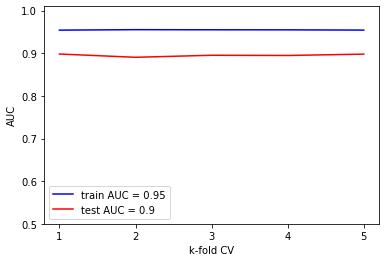

In [12]:
# Visualize the train, test score
plt.plot(scores_df['train'], color='blue')
plt.plot(scores_df['test'], color='red')
plt.ylim(0.5, 1.01)
plt.xticks(scores_df.index, scores_df.index+1)
plt.xlabel('k-fold CV')
plt.ylabel('AUC')
plt.legend(('train AUC = ' + str(np.round(scores_df['train'].mean(), 2)),
            'test AUC = ' + str(np.round(scores_df['test'].mean(), 2))))
plt.show()

## Performing Final Prediction

### Fitting the Best Model with the best parameters

In [ ]:
# Defining the model with the best parameters
catboost  = CatBoostClassifier(task_type = 'CPU',verbose=False)
models = {"catboost" : catboost}

In [ ]:
#fitting the best model
for model in models:
    models[model].fit(train[selectedFeatures],train[target])
    print(f"{model} has been trained successfully")

### Predicting on the test dataset

In [19]:
#creating a prediction table with id's from our predict set
prediction = pd.DataFrame(columns = ["ID_code","target"])
prediction["ID_code"] = test["ID_code"]

In [20]:
#function to predict and save result
def save_prediction(model,my_file):
    model_predict = model.predict(my_file[features])
    model_proba = pd.DataFrame(model.predict_proba(my_file[features]))[1]
    prediction["target"] = pd.DataFrame(model_proba)
    prediction.to_csv('my_predictions.csv', index=False)

In [31]:
save_prediction(catboost,test)